In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Imports

import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report)

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from joblib import dump
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

print('Imports successful')

Imports successful


In [3]:
#Load and clean data set

df = pd.read_csv(r"C:\Users\jacov\anaconda_projects\Model Engineering\Data for Task 1.csv")

# Drop unnecessary columns if they exist
df.drop(columns=['id', 'Unnamed: 32'], errors='ignore', inplace=True)

#Set a save_path for graphs
save_path = r"C:\Users\jacov\anaconda_projects\Model Engineering\EDA_graphs"
os.makedirs(save_path, exist_ok=True)

print("Dataset Loaded:", df.shape)
df.head()

Dataset Loaded: (569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
#Prepare data
X = df.drop(columns='diagnosis')
y = df['diagnosis']

#Encode labels for clarity (M=1, B=0)
y = y.map({'M': 1, 'B': 0})

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26, stratify=y) #Keep benign-malignant class ratio 

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


#Define models for training

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=26),
    'Decision Tree': DecisionTreeClassifier(random_state=26),
    'Random Forest': RandomForestClassifier(max_depth=3, random_state=26),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Ridge Classifier': RidgeClassifier(random_state=26)
}

results = []

#Loop through models
for name, model in models.items():
    pipe = Pipeline([('scaler', StandardScaler()),('model', model)])
    pipe.fit(X_train, y_train)
    
    #Predictions
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    #Handle ROC AUC safely
    try:
        y_prob = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    except Exception:
        auc = np.nan

    results.append({
        'Model': name,
        'Train Accuracy': accuracy_score(y_train, y_pred_train),
        'Test Accuracy': accuracy_score(y_test, y_pred_test),
        'F1': f1_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'ROC_AUC': auc
    })

df_results = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False)
df_results.reset_index(drop=True, inplace=True)
df_results.to_csv('train_model_result_metrics.csv')
df_results


Training set: (455, 30), Testing set: (114, 30)


,Model,Train Accuracy,Test Accuracy,F1,Precision,Recall,ROC_AUC
0,Logistic Regression,0.989011,0.973684,0.963855,0.975610,0.952381,0.996032
1,KNN,0.982418,0.956140,0.939759,0.951220,0.928571,0.978009
2,Ridge Classifier,0.962637,0.956140,0.938272,0.974359,0.904762,NaN
3,Random Forest,0.984615,0.938596,0.915663,0.926829,0.904762,0.993717
4,Naive Bayes,0.938462,0.921053,0.894118,0.883721,0.904762,0.987434
5,Decision Tree,1.000000,0.903509,0.879121,0.816327,0.952381,0.913690


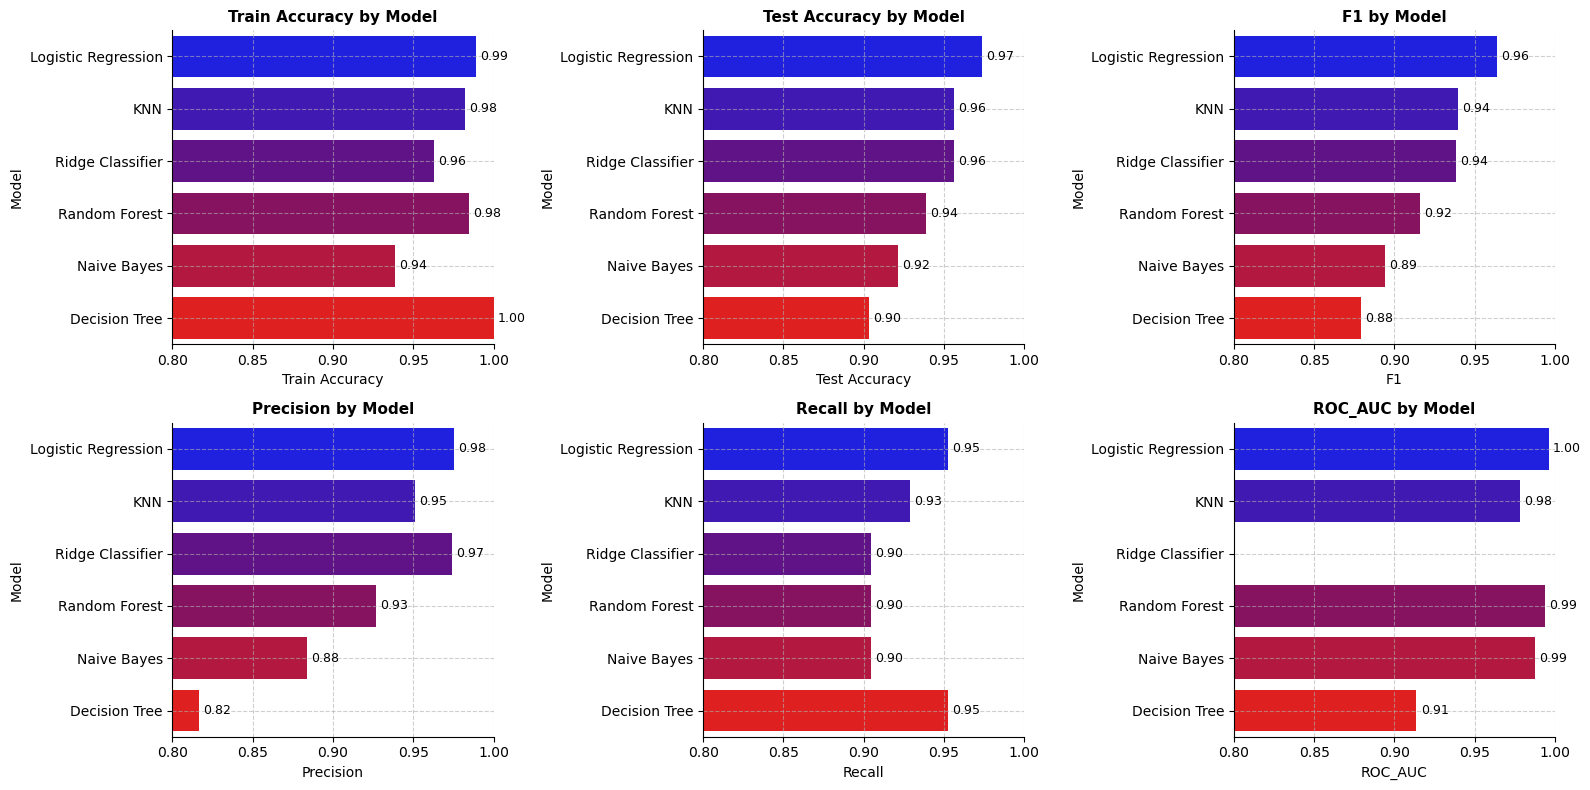

In [5]:
#Vizualize model results

#layout
metrics = ['Train Accuracy', 'Test Accuracy', 'F1', 'Precision', 'Recall', 'ROC_AUC']
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

colors = sns.color_palette("blend:blue,red", n_colors=len(df_results))

for i, metric in enumerate(metrics):
    sns.barplot(data=df_results, x=metric, y='Model', ax=axes[i], palette=colors)
    axes[i].set_title(metric + " by Model", fontsize=11, fontweight='bold')
    axes[i].set_xlim(0.8, 1)
    for c in axes[i].containers:
        axes[i].bar_label(c, fmt='%.2f', fontsize=9, padding=3)

axes[0].axis('on')  
for ax in axes:
    sns.despine(ax=ax, left=False, bottom=False)  
    ax.grid(True, linestyle='--', alpha=0.6)      

plt.tight_layout()
plt.savefig(os.path.join(save_path, "test_results.png"), dpi=300, bbox_inches='tight')
plt.show()

In [6]:
#Logistic regression has best results

#Define Logistic regression pipeline
log_pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000, random_state=26))])

#Parameter grid for model
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__solver': ['liblinear', 'lbfgs'],
    'logreg__penalty': ['l2'],
}

#Define KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=26)

#GridSearchCV
grid_search = GridSearchCV(log_pipe, param_grid, cv=kf, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Val Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Val Accuracy: 0.9802197802197803


In [7]:
#Final Evaluation
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)


print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, digits=4))



Classification Report:
              precision    recall  f1-score   support

           0     0.9726    0.9861    0.9793        72
           1     0.9756    0.9524    0.9639        42

    accuracy                         0.9737       114
   macro avg     0.9741    0.9692    0.9716       114
weighted avg     0.9737    0.9737    0.9736       114



In [8]:
#Save_final model results as csv

df_final_results = pd.DataFrame([{
    'Model': 'Logistic Regression (Final)',
    'Train Accuracy': accuracy_score(y_train, best_model.predict(X_train)),
    'Test Accuracy': accuracy_score(y_test, y_pred_final),
    'F1': f1_score(y_test, y_pred_final),
    'Precision': precision_score(y_test, y_pred_final),
    'Recall': recall_score(y_test, y_pred_final),
    'ROC_AUC': roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])
}])

df_final_results.to_csv('final_model_result_metrics.csv', index=False)

print("Saved as 'final_model_result_metrics.csv'")


Saved as 'final_model_result_metrics.csv'


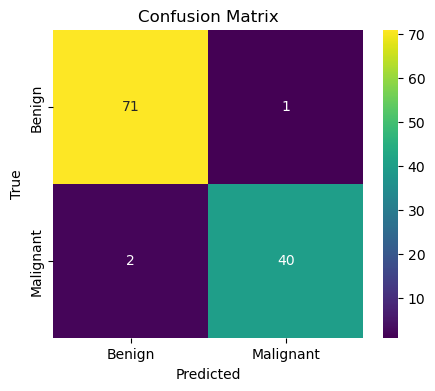

In [9]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Benign','Malignant'], yticklabels=['Benign','Malignant'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(save_path, "confusion_matrix_logreg.png"), dpi=300, bbox_inches='tight')
plt.show()



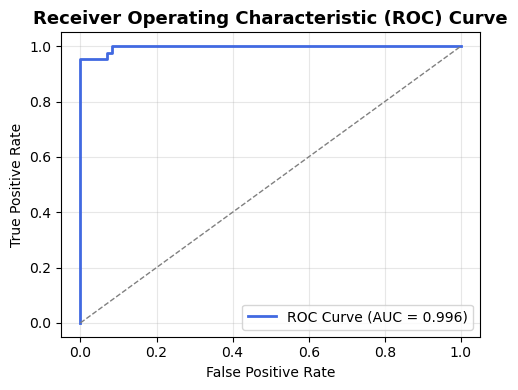

In [10]:
#ROC Curve
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='royalblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=13, weight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "roc_curve_logreg.png"), dpi=300, bbox_inches='tight')
plt.show()

In [11]:
#Save Final Model
model_filename = f"logistic_regression_final_{datetime.now().strftime('%Y%m%d')}.joblib"
dump(best_model, model_filename)
print(f" Model saved as: {model_filename}")

 Model saved as: logistic_regression_final_20251106.joblib


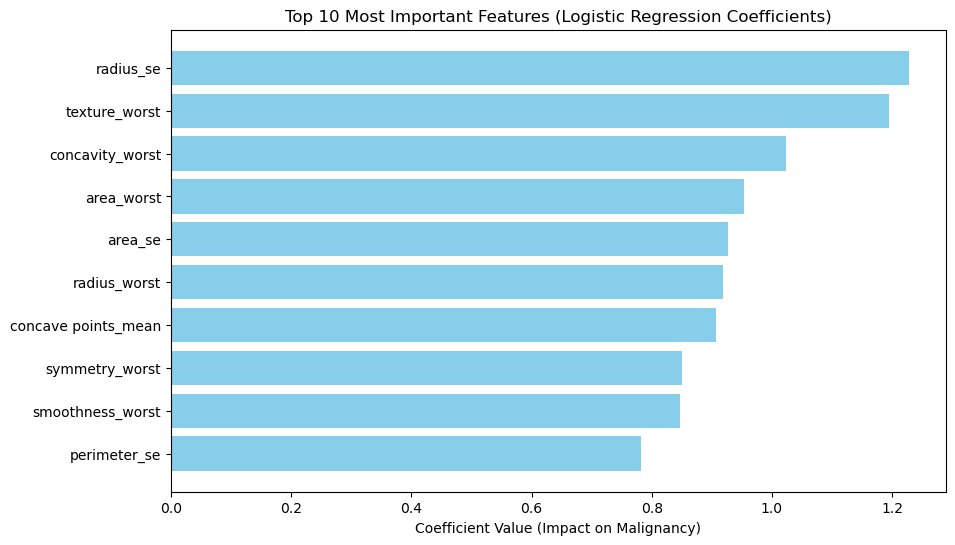

In [12]:
# Get model coefficients
coefs = best_model.named_steps['logreg'].coef_[0]
features = X.columns

# Sort by importance
importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefs,
    'AbsValue': np.abs(coefs)
}).sort_values('AbsValue', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(importance['Feature'][:10], importance['Coefficient'][:10], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Most Important Features (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value (Impact on Malignancy)")
plt.savefig(os.path.join(save_path, "Top12_important_features.png"))
plt.show()



Error Summary:
error_type
Correct           111
False Negative      2
False Positive      1
Name: count, dtype: int64 



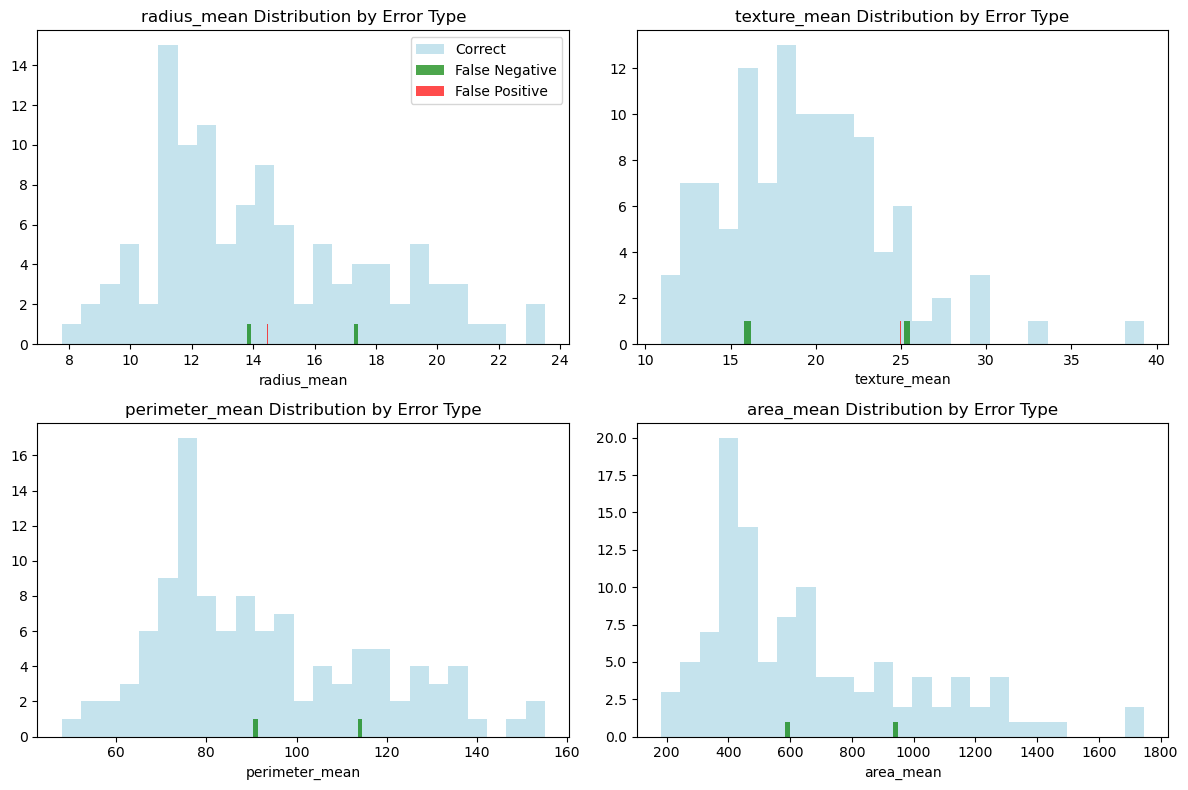

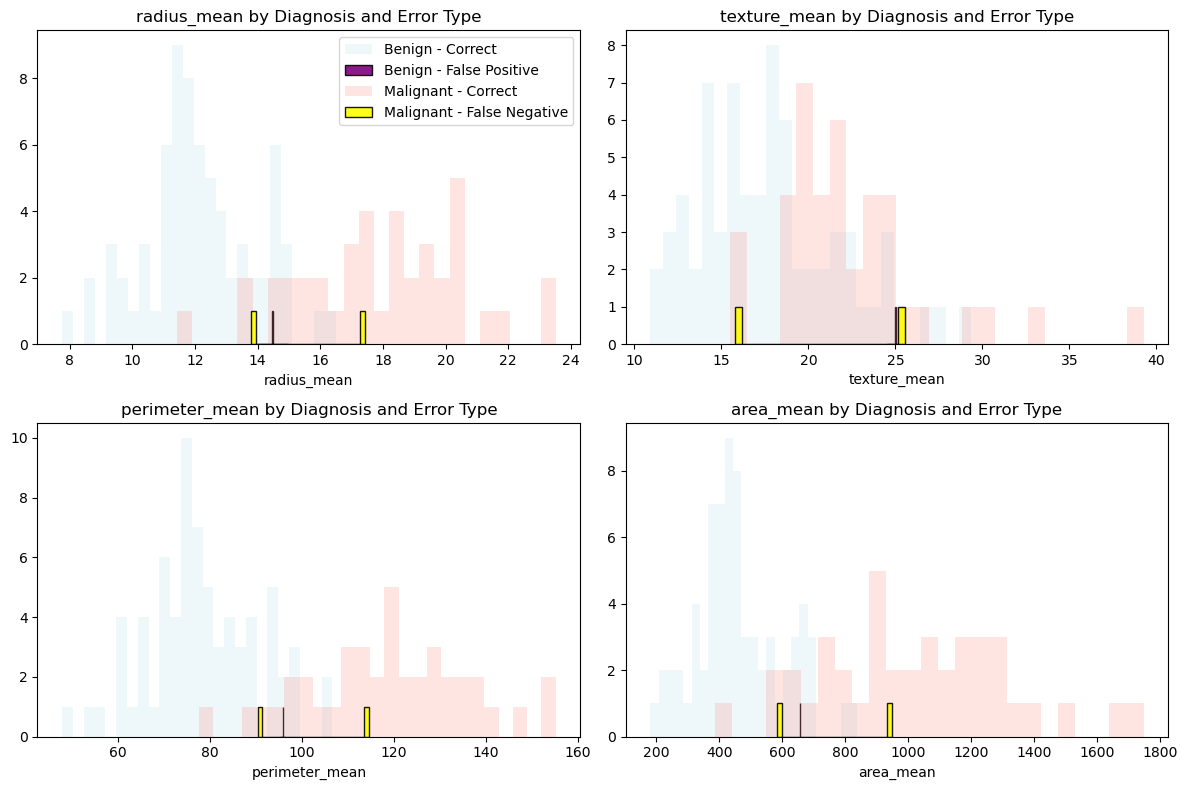

Saved: error_analysis_by_type.png and error_analysis_combined.png


In [19]:
#Combined Error Analysis
#Show where features of the missclassified cases were on a graph


def error_analysis_combined(best_model, X_test, y_test, y_pred, save_path):
    import matplotlib.pyplot as plt
    import pandas as pd
    import os

    #Ensure y_test and y_pred align by index
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    #Build analysis DataFrame
    error_df = X_test.copy()
    error_df['actual_num'] = y_test
    error_df['predicted_num'] = y_pred_series
    error_df['actual'] = error_df['actual_num'].map({0: 'Benign', 1: 'Malignant'})
    error_df['predicted_label'] = error_df['predicted_num'].map({0: 'Benign', 1: 'Malignant'})
    error_df['correct'] = error_df['actual'] == error_df['predicted_label']

    #Define error type
    error_df['error_type'] = 'Correct'
    error_df.loc[(error_df['actual'] == 'Malignant') & (error_df['predicted_label'] == 'Benign'), 'error_type'] = 'False Negative'
    error_df.loc[(error_df['actual'] == 'Benign') & (error_df['predicted_label'] == 'Malignant'), 'error_type'] = 'False Positive'

    #Print error summary
    print("\nError Summary:")
    print(error_df['error_type'].value_counts(), "\n")

    #Create graphs
    top_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']

    #Distribution by error type
    colors_error = {'Correct': 'lightblue', 'False Negative': 'green', 'False Positive': 'red'}

    plt.figure(figsize=(12, 8))
    for i, feature in enumerate(top_features, 1):
        plt.subplot(2, 2, i)
        for error_type, color in colors_error.items():
            subset = error_df[error_df['error_type'] == error_type]
            if len(subset) > 0:
                plt.hist(subset[feature], alpha=0.7, label=error_type, bins=25, color=color)
        plt.title(f"{feature} Distribution by Error Type")
        plt.xlabel(feature)
        if i == 1:
            plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "error_analysis_by_type.png"), dpi=300, bbox_inches='tight')
    plt.show()

    #Distribution by Diagnosis with Error Overlay
    #Color selection
    class_colors = {'Benign': 'lightblue', 'Malignant': 'salmon'}
    #Different color for errors - Can choose dif color until it stands out from the classification graph  
    highlight_FP_color = "purple"     
    highlight_FN_color = "yellow"     

    #Define colors for specific error overlays
    overlay_colors = {('Benign', 'False Positive'): highlight_FP_color, ('Malignant', 'False Negative'): highlight_FN_color}
    error_styles = {'Correct': 0.2, 'False Positive': 0.9, 'False Negative': 0.9}

    plt.figure(figsize=(12, 8))
    for i, feature in enumerate(top_features, 1):
        plt.subplot(2, 2, i)

        for diagnosis, base_color in class_colors.items():
            for error_type, alpha_val in error_styles.items():
                subset = error_df[(error_df['actual'] == diagnosis) & (error_df['error_type'] == error_type)]

                if len(subset) > 0:
                    #FP or FN, use highlight color 
                    color_to_use = overlay_colors.get((diagnosis, error_type), base_color)

                    plt.hist(
                        subset[feature],
                        bins=25,
                        alpha=alpha_val,
                        label=f"{diagnosis} - {error_type}",
                        color=color_to_use,
                        edgecolor='black' if error_type != 'Correct' else None,
                        linewidth=1.0 if error_type != 'Correct' else 0
                    )

        plt.title(f"{feature} by Diagnosis and Error Type")
        plt.xlabel(feature)
        if i == 1:
            plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "error_analysis_combined.png"), dpi=300, bbox_inches='tight')
    plt.show()

    print("Saved: error_analysis_by_type.png and error_analysis_combined.png")
    return error_df


#Run
error_df = error_analysis_combined(best_model, X_test, y_test, y_pred_final, save_path)